In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

# Disturbance

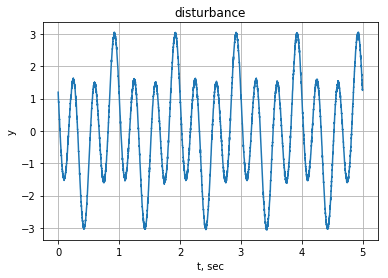

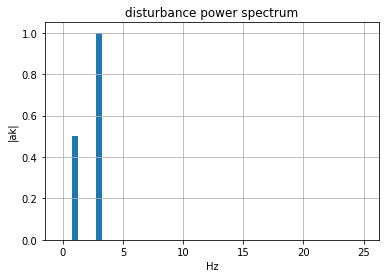

In [2]:
def gen_disturbance(plot=False):
    dt = 0.001
    tf = 5
    t = np.arange(0, tf, dt)
    d = 1*np.sin(2*np.pi*1*t + 2) + 2*np.sin(2*np.pi*3*t + 3) + 1*np.random.randn(len(t))*dt**(0.5)
    np.savetxt('data/disturbance.csv', np.vstack([t, d]).T, delimiter=',', header='t, d',  fmt='%g')
    ak = np.fft.ifft(d);
    k = np.arange(0, len(ak)//40)

    if plot:
        plt.figure()
        plt.plot(t, d)
        plt.grid()
        plt.xlabel('t, sec')
        plt.ylabel('y')
        plt.title('disturbance')

        plt.figure()
        plt.bar(k/tf, np.abs(ak[k]), width=0.5)
        plt.ylabel('|ak|')
        plt.xlabel('Hz')
        plt.grid()
        plt.title('disturbance power spectrum')
gen_disturbance(plot=True)

# Noise

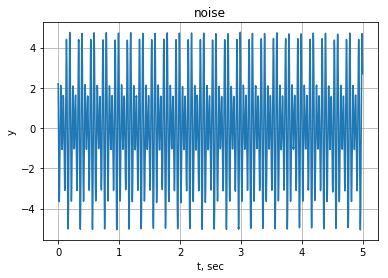

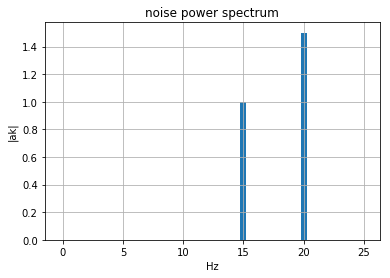

In [3]:
def gen_noise(plot=False):
    dt = 0.001
    tf = 5
    t = np.arange(0, tf, dt)
    n = 2*np.sin(2*np.pi*15*t + 2) + 3*np.sin(2*np.pi*20*t + 3) + 1*np.random.randn(len(t))*dt**(0.5)
    np.savetxt('data/noise.csv', np.vstack([t, n]).T, delimiter=',', header='t, n', fmt='%g')
    ak = np.fft.ifft(n);
    k = np.arange(0, len(ak)//40)

    if plot:
        plt.figure()
        plt.plot(t, n)
        plt.grid()
        plt.xlabel('t, sec')
        plt.ylabel('y')
        plt.title('noise')

        plt.figure()
        plt.bar(k/tf, np.abs(ak[k]), width=0.5)
        plt.ylabel('|ak|')
        plt.xlabel('Hz')
        plt.grid()
        plt.title('noise power spectrum')
gen_noise(plot=True)

In [4]:
def simulate_spacecraft_docking(G, H):
    """
    @param G: The Laplace transform of X/T, x position over thrust
    @param H: Your controller with noise filter.
    """
    noise = np.loadtxt('data/noise.csv', delimiter=',')
    disturbance = np.loadtxt('data/disturbance.csv', delimiter=',')
    t = noise[:, 0]
    reference = 1 + 0.1*t**2  # the reference trajectory

    
    # find transfer functions for error, e
    Ge_r = control.minreal(1/(1+G*H), verbose=False)
    Ge_n = -Ge_r
    Ge_d = control.minreal(-G/(1+G*H), verbose=False)
    
    # find transfer functions for output, y
    Gy_r = control.minreal(G*H/(1+G*H), verbose=False)
    Gy_n = -Gy_r
    Gy_d = control.minreal(G/(1+G*H), verbose=False)

    # compute output
    y_r = control.forced_response(Gy_r, U=reference, T=t)[1];
    y_n = control.forced_response(Gy_n, U=noise[:, 1], T=t)[1];
    y_d = control.forced_response(Gy_d, U=disturbance[:, 1], T=t)[1];
    y = y_r + y_n + y_d
    
    e = y - reference
    
    vx = 1
    t1 = t[-1]
    t0 = t1 - 2
    
    i0 = np.argmax(t > t0)
    
    x0 = vx*t0
    x1 = vx*t1
    
    error_tol = 0.1
    plt.figure(figsize=(10, 5))
    plt.plot(t, e)
    plt.plot(x1, 0, 's', markersize=10, label='space station')
    plt.hlines(error_tol, x0, x1, label='docking window', linewidth=3)
    plt.hlines(-error_tol, x0, x1, linewidth=3)
    plt.grid()
    plt.legend()
    plt.axis('equal')
    plt.xlabel('x error, m')
    plt.ylabel('y error, m')

    if np.any(np.abs(e[i0:]) > error_tol):
        print('CRASH')
    else:
        print('SUCCESSFUL DOCKING')
        
    return locals()

SUCCESSFUL DOCKING


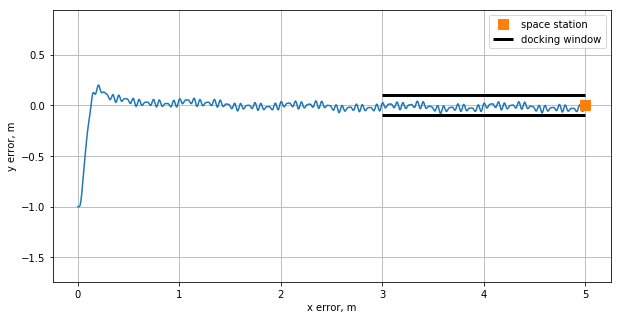

In [5]:
import control
import scipy.signal
from numpy import genfromtxt

def design():
    
    # load data for noise and disturbance for analysis
    noise = np.loadtxt('data/noise.csv', delimiter=',')
    disturbance = np.loadtxt('data/disturbance.csv', delimiter=',')

    # constants
    m = 1
    s = control.tf([1, 0], [0, 1])
    G = 1/(m*s**2)

    #########################################
    # ONLY CHANGE K, Wn, based on your design
    K = 10
    Wn = 5*2*np.pi

    #########################################
    H_noise_filter = control.tf(*scipy.signal.butter(N=2, Wn=Wn, analog=True))
    H_controller = K*(1 + 1*s)
    H = H_controller*H_noise_filter
    
    # find transfer functions for error
    Ge_r = control.minreal(1/(1+G*H), verbose=False)
    Ge_n = -Ge_r
    Ge_d = control.minreal(-G/(1+G*H), verbose=False)
    
    # find transfer functions for output, y
    Gy_r = control.minreal(G*H/(1+G*H), verbose=False)
    Gy_n = -Gy_r
    Gy_d = control.minreal(G/(1+G*H), verbose=False)
    
    return locals()

design_data = design()
sim_data = simulate_spacecraft_docking(design_data['G'], design_data['H']);

In [6]:
Ge_r = design_data['Ge_r']
s = control.tf([1, 0], [0, 1])
r_s = 0.1/s + 0.1*2/s**3  # laplace transform of reference input
e_r_ss = np.real(control.minreal(Ge_r*s*r_s, verbose=False)(0))
print("steady state error from reference trajectory: {:0.4g} cm".format(100*e_r_ss))

steady state error from reference trajectory: 2 cm


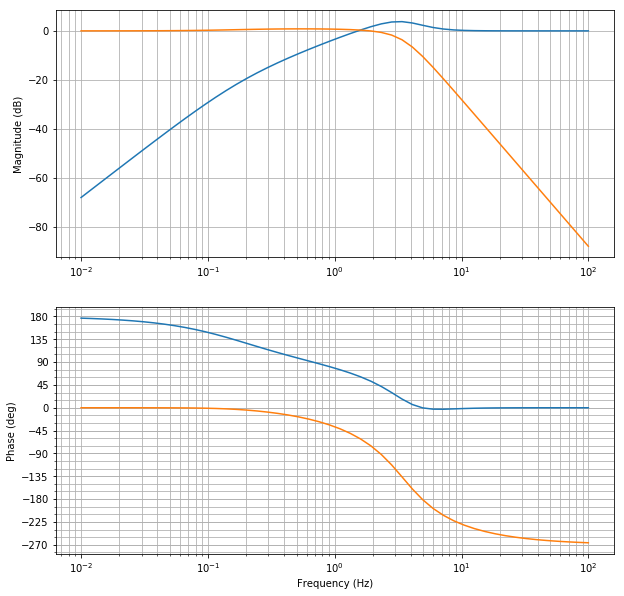

In [7]:
plt.figure(figsize=(10, 10))
control.bode([design_data['Ge_r'], design_data['Gy_r']], dB=True, Hz=True);

In [8]:
Gy_n = design_data['Gy_n']
e_n_ss_amp = 2*np.abs(Gy_n(15*2*np.pi*1j)) + 3*np.abs(Gy_n(20*2*np.pi*1j))
e_n_ss_amp
print("steady state noise amplitude in output: {:0.4g} cm".format(100*e_n_ss_amp))

steady state noise amplitude in output: 3.848 cm


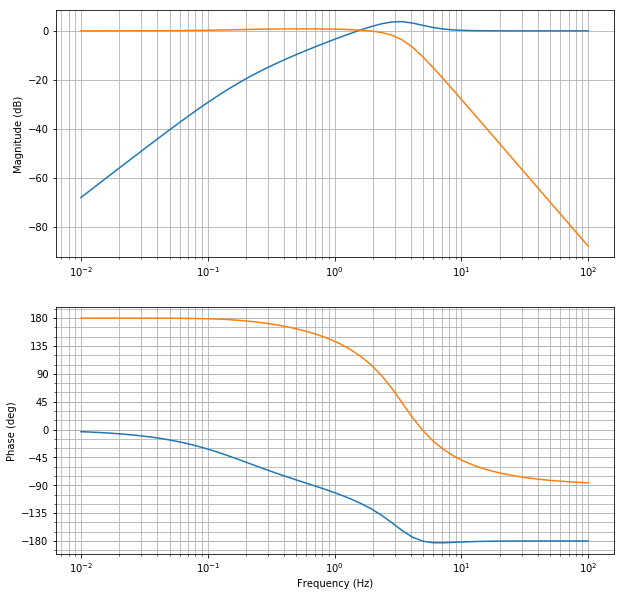

In [9]:
plt.figure(figsize=(10, 10))
control.bode([design_data['Ge_n'], design_data['Gy_n']], dB=True, Hz=True);

In [10]:
Gy_d = design_data['Gy_d']
e_d_ss_amp = 2*np.abs(Gy_d(2*2*np.pi*1j)) + 3*np.abs(Gy_d(3*2*np.pi*1j))
print("steady state disturbance amplitude in output: {:0.4g} cm".format(100*e_d_ss_amp))

steady state disturbance amplitude in output: 2.885 cm


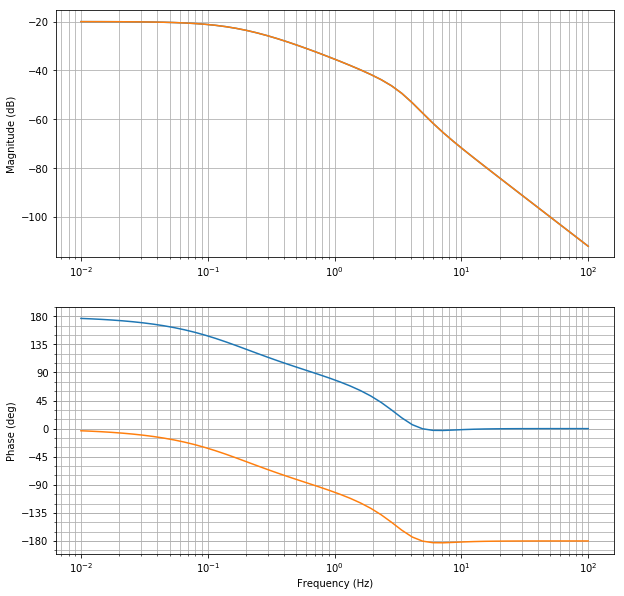

In [11]:
plt.figure(figsize=(10, 10))
control.bode([design_data['Ge_d'], design_data['Gy_d']], dB=True, Hz=True);

In [12]:
e_total = e_r_ss + e_n_ss_amp + e_d_ss_amp
e_tol = sim_data['error_tol']
print("total error: {:0.4g} cm, docking tolerance {:0.4g} cm".format(100*e_total, 100*0.1))
if e_total < e_tol:
    print('theory predicts successful docking')
else:
    print('theory predicts crash')

total error: 8.733 cm, docking tolerance 10 cm
theory predicts successful docking
